In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Task 1: Data Loading and Initial Exploration

In [2]:
df = pd.read_excel("data/titanic3.xls") # This DF is reserved for model training 
dfEDA = df.copy() # This is a copy of the dataframe I will use to do eda I realsied that I should have include this in the beggining 
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# First I want to look at the number of rows and columns
print(f"Dataset Shape:{dfEDA.shape}") 

Dataset Shape:(1309, 14)


Personal Thoughts/Interpretation:
- We see there are 1309 passangers (rows) and 14 features (columns)

In [4]:
# Show column data types and names
print("\nColumn Data Types:")
print(dfEDA.dtypes) 


Column Data Types:
pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object


Personal Thoughts/Interpretation:
- Mix of numerical and categorical variables
- Target variable in this case is 1 = Survived 0 = Died

In [5]:
# Now for how many missing values we have to account for
print("\nMissing Values per Column:")
print(dfEDA.isnull().sum()) 


Missing Values per Column:
pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


Personal Thoughts/Interpretation:

- Cabin has a lot of missing values as well as bodies who I assume where never found 
- Furthermore home destination has a lot of missing values and boat which I can only assume is life boats

- Cabin will most likley be very difficult to handle missing values as they are so many
- home.dest at first glance seems like an irrelevant factor but could point towards socio economic standing

In [6]:
dfEDA.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


Personal Thoughts/Interpretation:

- in this dataset 38% of passangers survived 
- we have an almost equal distribution (STD = 0.49) of survivors and non-survivors
- Most passangers where not in first class -> mean = 2.29
- could hint that we should compare survival rates by 

- Age could also be a factor here women and children likely had a priority meaning mainly men would have dided

- Most people on board where travelling alone or with one family member (mean 0.5) -> sibsp
- Maybe family onboard could have implied better survival chances

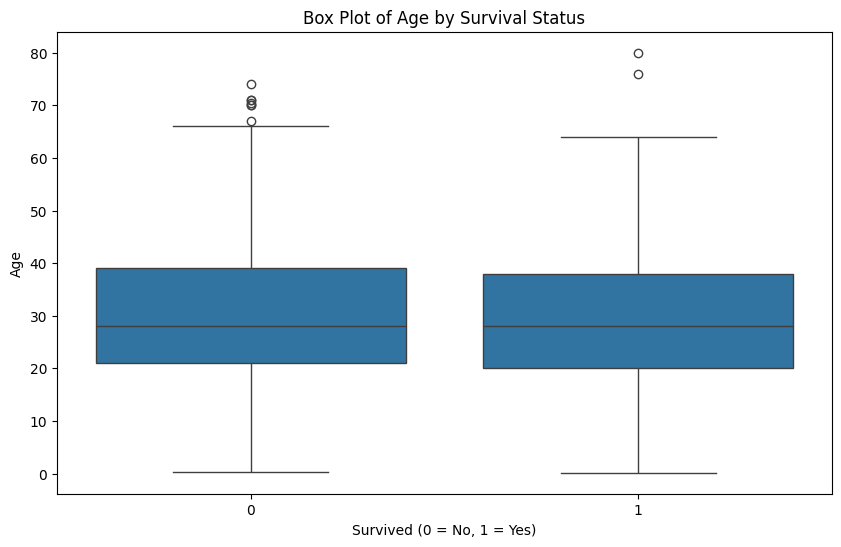

In [7]:
## Box Plot for age 

plt.figure(figsize=(10, 6))
sns.boxplot(x='survived', y='age', data=df)
plt.title("Box Plot of Age by Survival Status")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.show()

Personal Thoughts/Interpretation:

- Median age is almost the same wether you survived or died 
- The age distribution appears to be almost identical for surviving or dying 
- Quite a few older passangers who did not survive could be used as an indication for survival

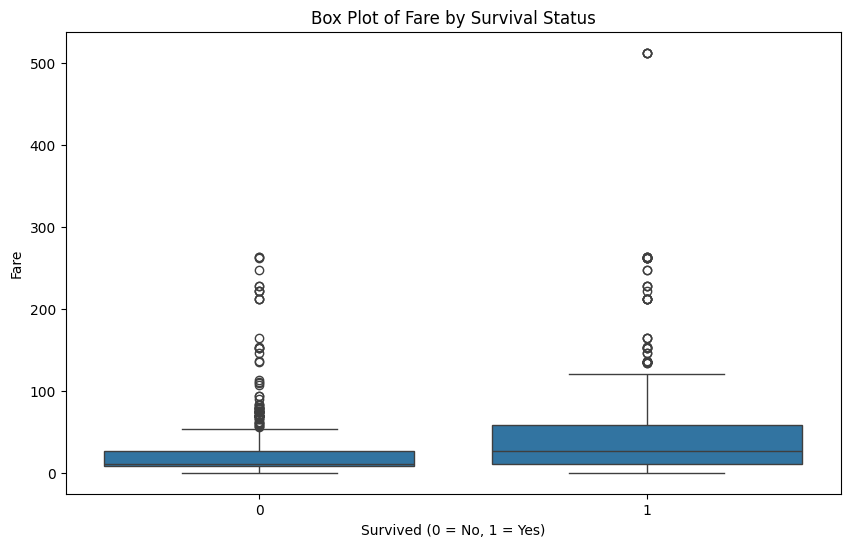

In [8]:
# Box plot for fare or class 

plt.figure(figsize=(10, 6))
sns.boxplot(x='survived', y='fare', data=df)
plt.title("Box Plot of Fare by Survival Status")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Fare")
plt.show()

Personal Thoughts/Interpretation:
- Median fare is much higher for those who survived indincating that economic status plays a role
- On the other hand are outliers we need to account for here 

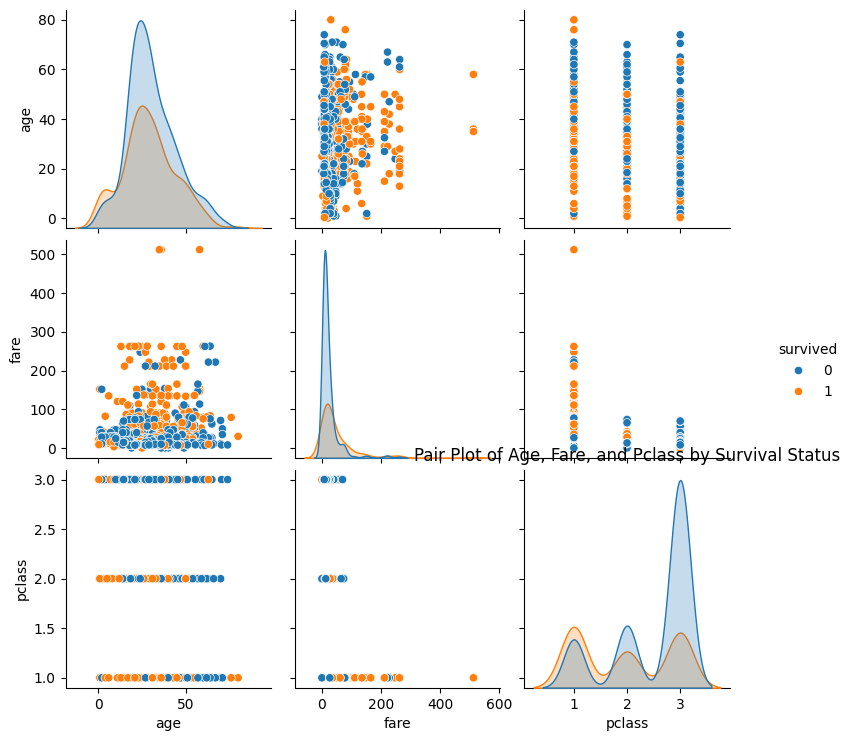

In [9]:
#First a pair plot to see the features relationship with the target variable. Specifically AGE, FARE, Pclass 

sns.pairplot(df, hue='survived', vars=['age', 'fare', 'pclass'])
plt.title("Pair Plot of Age, Fare, and Pclass by Survival Status")
plt.show()

Personal Thoughts/Interpretation:
- For the model we need to remember the following 
- Fare has outliers we need to deal with
- Pclass should probably be treated as a numerical variable with one-hot encoding
- Maybe age could be turned into a category 0-12-> Child 13->19 Teen etc.
- Fare and Class are correlated so we should remove Fare probably due to multicollinearity issues

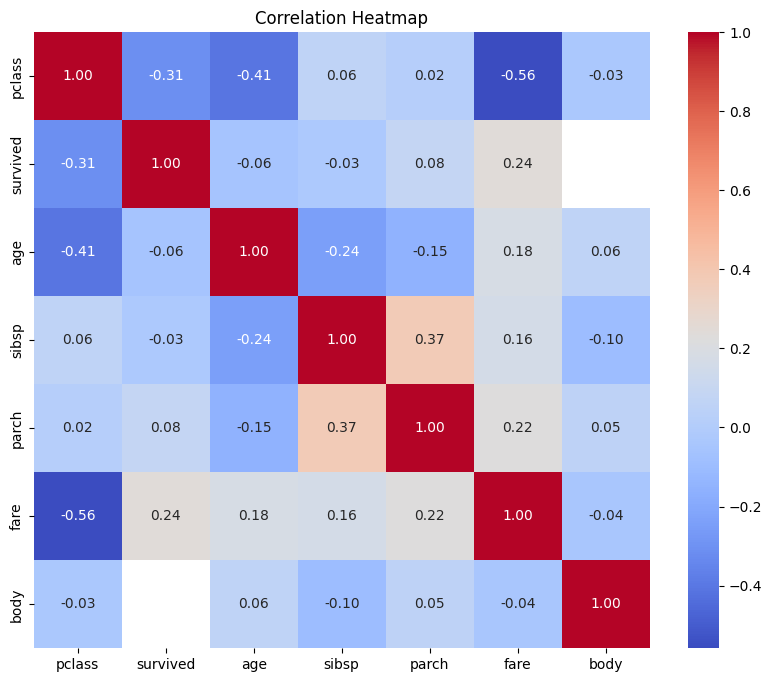

In [10]:
# CORRELATION HEAT MAP USING ONLY NUMERIC VALUES

numericDF = dfEDA.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numericDF.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

Personal Thoughts/Interpretation:

- One further analysis this correlation map does not provide valuable inforamtion. Leading me to want to explore categorical variables in more depth with count plots and pie charts 

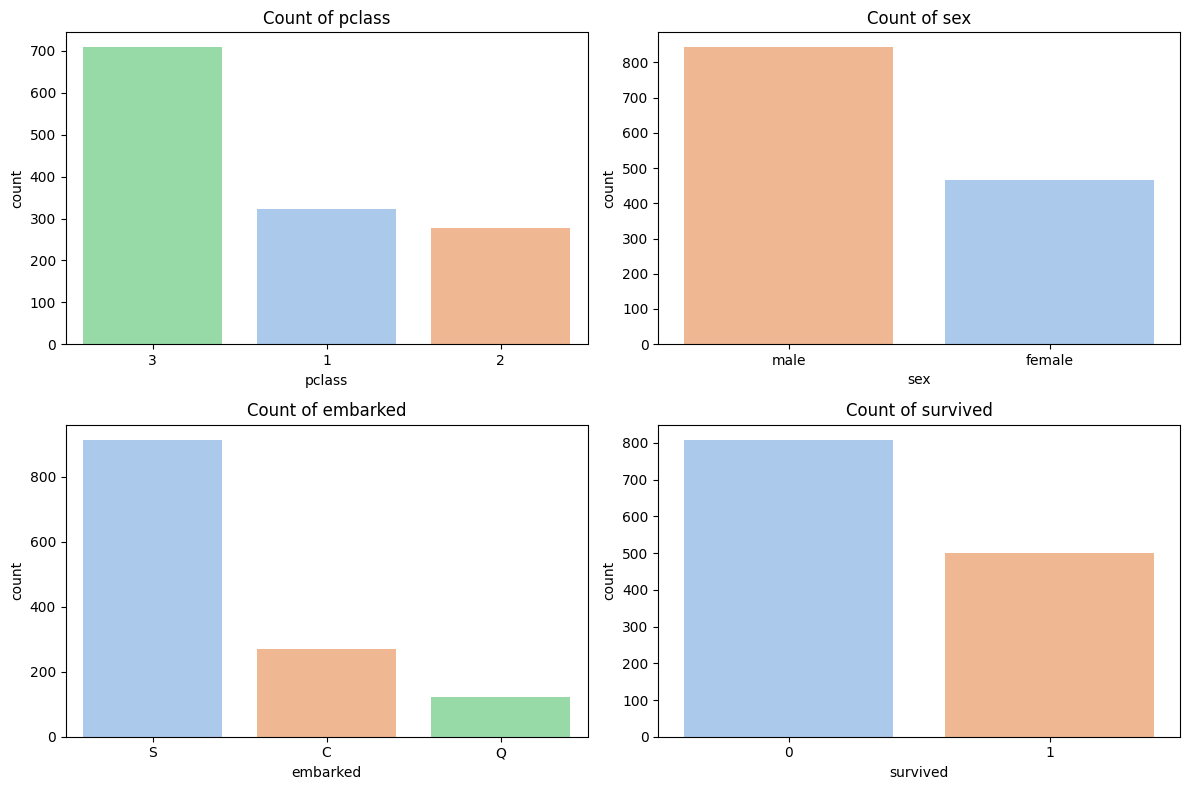

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
categoricalCols = ['pclass', 'sex', 'embarked', 'survived']

for col, ax in zip(categoricalCols, axes.flatten()):
    if col in dfEDA.columns:
        sns.countplot(x=df[col], hue=df[col], ax=ax, order=df[col].value_counts().index, palette="pastel", legend=False)
        ax.set_title(f"Count of {col}")
    else:
        ax.set_title(f"{col} not found in dataset")

plt.tight_layout()
plt.show()


Passanger Class Distribution:
- As expected majority of passangers where in 3rd class
- Followed by fewer in 1st and second class
Gender Distribution:
- More Males exist in the data set
Embarkation Port:
- 

Columns I will drop:

Irrelevant data:
- Name -> Contributes to no meanigful survival information

Data leakage:
- Body -> Causes Data lekage as the person did not survive
- Boat -> Causes Data lekage beucase it implies data 

Columns I will be cautious to include/test and then make final decision:
- Cabin -> Due to many missing values (fare can already be an indication)
- Ticket -> Right now Looking at ticket number I can extract the grouping just by looking at it (must indicate class in some way)


# Task 2: Managing Missing Values

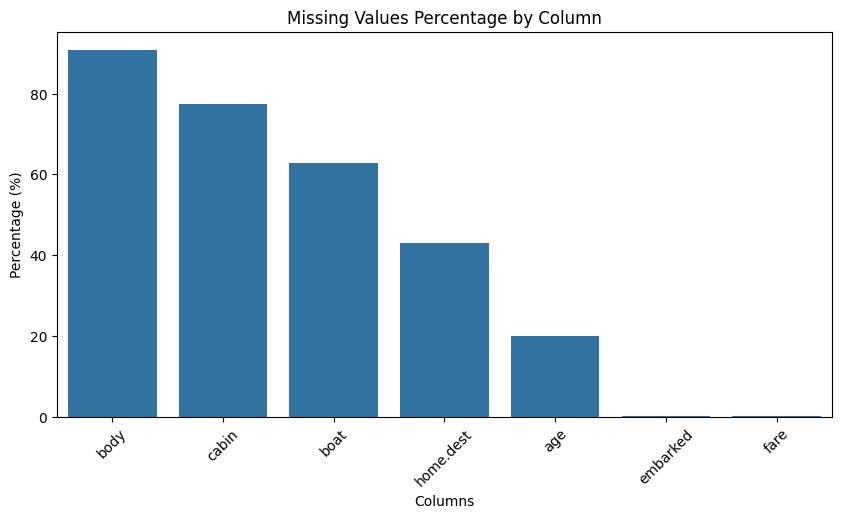

In [12]:
# Here Im checking for missing values
values_missing = df.isnull().sum()
percentage_missing = (values_missing / len(df)) * 100

# now I want to display this percentage wise and sorted

data_missing = pd.DataFrame({'Missing Values': values_missing, 'Percentage': percentage_missing })
data_missing = data_missing[data_missing['Missing Values']> 0].sort_values(by='Percentage', ascending = False)

plt.figure(figsize =(10,5))
sns.barplot(x=data_missing.index, y = data_missing['Percentage'])
plt.xticks(rotation=45)
plt.title("Missing Values Percentage by Column")
plt.xlabel("Columns")
plt.ylabel("Percentage (%)")
plt.show()


In [13]:
# Dropping Columns I justified earlier

df.drop(columns = ['name', 'body', 'boat'], inplace = True)

# Check the new data frame
df.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1,1,female,29.0000,0,0,24160,211.3375,B5,S,"St Louis, MO"
1,1,1,male,0.9167,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
2,1,0,female,2.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
3,1,0,male,30.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
4,1,0,female,25.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"


Now lets look at home destination. Since over 40% of values are missing it could be better to remove it however it could correlate with socio economic status. I will check this by correlating home destiantion with survival.

/var/folders/yl/65z9g7mx6y1bg414kdj3sw0w0000gn/T/ipykernel_50553/2606246572.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['home.dest'].notnull(), y=df['survived'], palette="coolwarm")


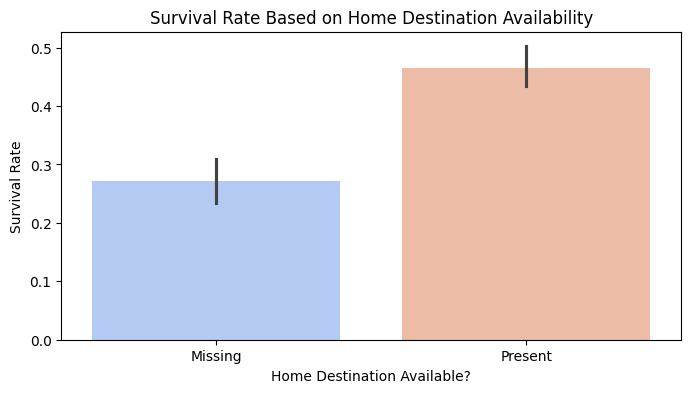

In [14]:
# Home destination correlation with survival
plt.figure(figsize=(8,4))
sns.barplot(x=df['home.dest'].notnull(), y=df['survived'], palette="coolwarm")
plt.xticks([0,1], ['Missing', 'Present'])
plt.title("Survival Rate Based on Home Destination Availability")
plt.xlabel("Home Destination Available?")
plt.ylabel("Survival Rate")
plt.show()


Passengers with a recorded home.dest had a survival rate of ~45%, while those without it had a survival rate of ~30%.

Could be down to wealthier passangers having pre-arragned accomodations while migrnats may not have had permanent residence yet. If we go off the assumption that wealtheir people had access to life boats this could be a reasons why home destination correlates with survival.

That being said Since fare and pclass already indicate socio-economic status, keeping home.dest might not add much value. and we could drop it from the data set to simplify things.

In [15]:
df.drop(columns=['home.dest'], inplace=True)

In [16]:
df.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,female,29.0000,0,0,24160,211.3375,B5,S
1,1,1,male,0.9167,1,2,113781,151.5500,C22 C26,S
2,1,0,female,2.0000,1,2,113781,151.5500,C22 C26,S
3,1,0,male,30.0000,1,2,113781,151.5500,C22 C26,S
4,1,0,female,25.0000,1,2,113781,151.5500,C22 C26,S


I dont see how ticket has any importance here and based on the previous barplot cabin has so many missing values pclass and fare already can compensat for this by indicating wealth and class

In [17]:
df.drop(columns=['ticket'], inplace=True)
df.drop(columns=['cabin'], inplace=True)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


What about embarked does it correspond to survival rate by indincating social calss?

/var/folders/yl/65z9g7mx6y1bg414kdj3sw0w0000gn/T/ipykernel_50553/2741978674.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="embarked", y="survived", data=df, palette="coolwarm")


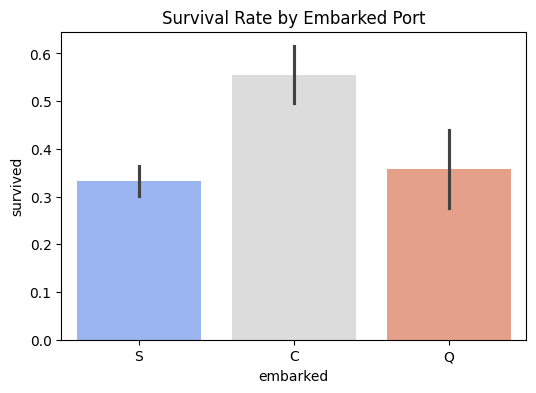

In [18]:
plt.figure(figsize=(6,4))
sns.barplot(x="embarked", y="survived", data=df, palette="coolwarm")
plt.title("Survival Rate by Embarked Port")
plt.show()


S -> Lowest survival rate ~ 30%
C -> Highest survival rate ~ 55%
Q -> Intermediate survival rate ~ 40%

Now I will move on to address missing columns: we already created a bar plot showing all the missing values but changed columns since then so lets update the barplot

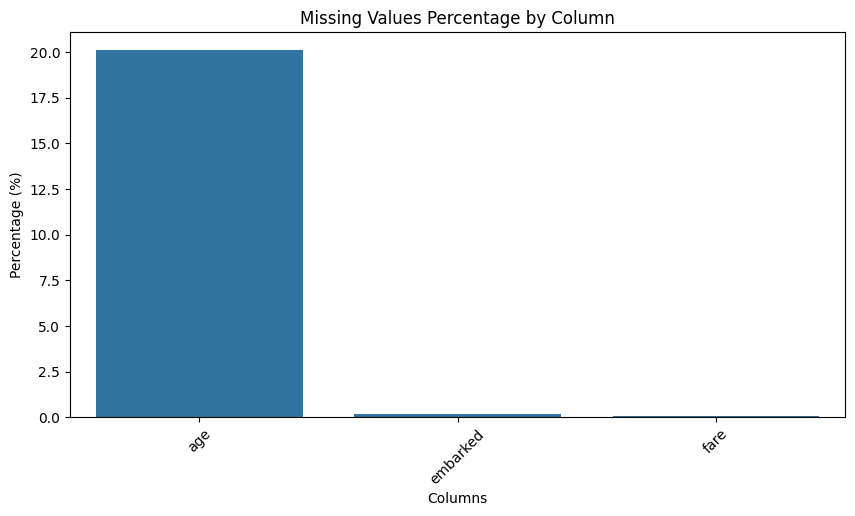

,Missing Values,Percentage
age,263,20.091673
embarked,2,0.152788
fare,1,0.076394


In [19]:
# Here Im checking for missing values
values_missing = df.isnull().sum()
percentage_missing = (values_missing / len(df)) * 100

# now I want to display this percentage wise and sorted

data_missing = pd.DataFrame({'Missing Values': values_missing, 'Percentage': percentage_missing })
data_missing = data_missing[data_missing['Missing Values']> 0].sort_values(by='Percentage', ascending = False)

plt.figure(figsize =(10,5))
sns.barplot(x=data_missing.index, y = data_missing['Percentage'])
plt.xticks(rotation=45)
plt.title("Missing Values Percentage by Column")
plt.xlabel("Columns")
plt.ylabel("Percentage (%)")
plt.show()

data_missing


In [20]:
# Print count of missing values for all columns
print(df.isnull().sum())


pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64


Now lets move on to the actual handling of missing values after dropping columns and looking at our result we need to handle age fare and embarked


For Fare -> Median since the mean 33.29 is much higher than the median of 14.45 indicating high outliers. This will avoid the effect of very expensive tickets

For Emabrked -> since there are only 2 missing values and categorical it is approbriate to use mode and not mean/median

In [21]:
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
df['fare'] = df['fare'].fillna(df['fare'].median())


In [22]:
# seeing if i did it correctly
print(df[['embarked', 'fare']].isnull().sum())


embarked    0
fare        0
dtype: int64


For Age -> I could use median imputation but this removes variability. I want to keep the natural relationship in the data without forcing all missing values to one static number. So I will use a linear reggression only if I can confire there is a linear relationship to do so I will first check the correlation matrix.


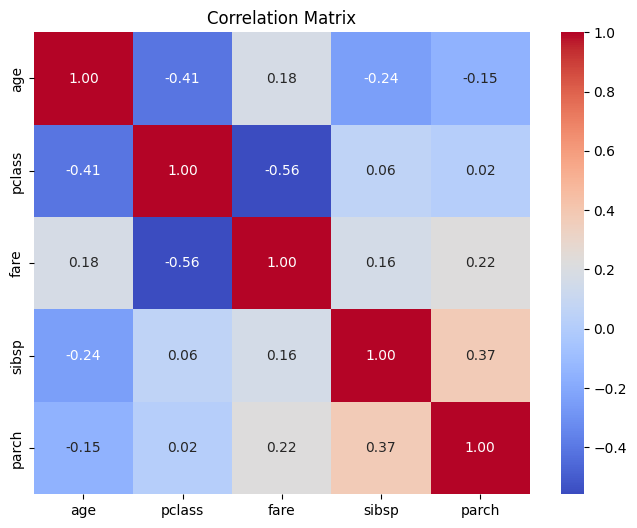

In [23]:
correlation_matrix = df[['age', 'pclass', 'fare', 'sibsp', 'parch']].corr()

# visualising
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


I will attempt to puruse this even though the correlation is weak. Knowing that multiple weakly correlated features can still improve accuracy 

In [24]:
# Features for prediction
features = ['pclass', 'fare', 'sibsp', 'parch']

# splitting the data into training and test sets
trainingData = df[df['age'].notnull()]
xTrain, xTest, yTrain, yTest = train_test_split(trainingData[features],trainingData['age'],test_size = 0.2, random_state=42)


# train the model

modelRegressionImputation = LinearRegression()
modelRegressionImputation.fit(xTrain, yTrain)

# make the prediction

yPred = modelRegressionImputation.predict(xTest)

# Evaluate the performance

mse = mean_squared_error(yTest, yPred)
r2 = r2_score(yTest, yPred)

print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")  # Closer to 1 means better fit


MSE: 149.8663
R2: 0.1730


MSE is high and shows errors in this model

r^2 is very low indicating the model doesnt explain variance in the data. I could choose more variables and encode them this could just introduce a lot of complexity as im encoding features in the data imputation step when that should be the next step. However I will not be pursuing this as I want to adheare to code cleanliness & pipeline consistency. Encoding categorical variables at this stage could introduce inconsistencys and should be treated as a dedicated step in the pipeline, not intermixed with missing value imputation. Furthermore encoding categorical variables before regression impuations means handling feature transformation at a stage that is to early adding a lot of complexity to the workflow. One-hot encoding would introduce multiple new columsn increasing the dimensionality. I attempted to do regression imputaion with numerical values and saw that It did not work. I want to keep this simple and as isolated as possible so for age I will just use median imputation. After looking online I found that I could modify imputation and do it by groups which seems like a nice twist that can add some nuance to age rather than just looking at the global median and blindly applying it.

Here are the groups I chose and why: 

Pclass -> from the EDA phase and intuition I believe that passanger class strucutre strongly influneced demographics. Higher class pasangers where typically older (signified by wealth, or business travlers).

Sex -> age distribution amongst men and women could be differnet due to travel patterns. Women traveling in 1st class are likley to be older or travelling with family while men in 3rd class where younger travelling alon for work or migration. 

Below I will attempt to prove these assumptions

/var/folders/yl/65z9g7mx6y1bg414kdj3sw0w0000gn/T/ipykernel_50553/2003303222.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="pclass", y="age", data=dfEDA, palette="coolwarm")


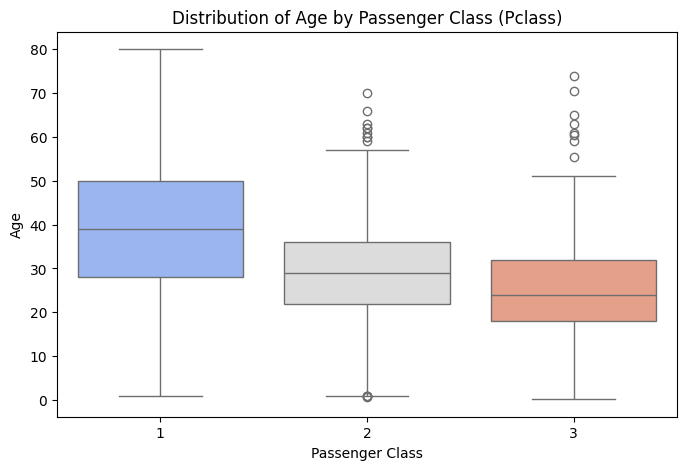

/var/folders/yl/65z9g7mx6y1bg414kdj3sw0w0000gn/T/ipykernel_50553/2003303222.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sex", y="age", data=dfEDA, palette="viridis")


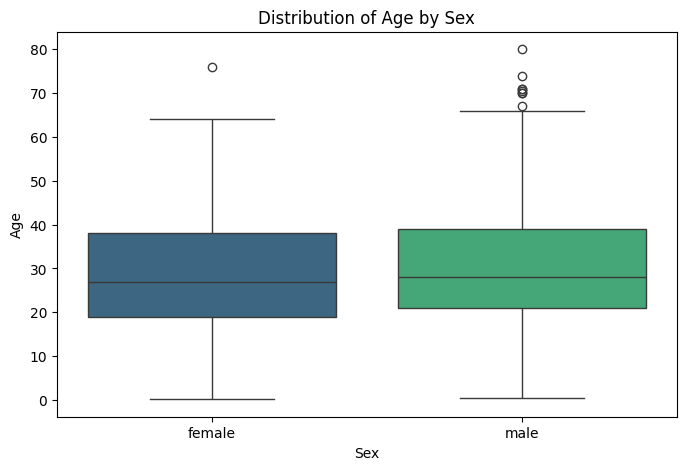

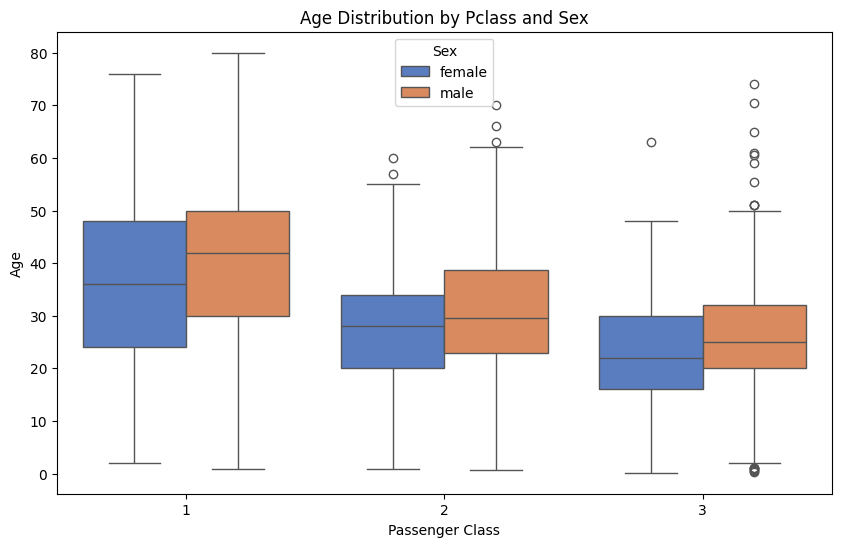

In [25]:
# Making a copy of the dataframe
dfEDA = df.dropna(subset=['age'])

# Plotting realtionship  between age and passanger class
plt.figure(figsize=(8,5))
sns.boxplot(x="pclass", y="age", data=dfEDA, palette="coolwarm")
plt.title("Distribution of Age by Passenger Class (Pclass)")
plt.xlabel("Passenger Class")
plt.ylabel("Age")
plt.show()


# Plotting relationship beteween age and sex
plt.figure(figsize=(8,5))
sns.boxplot(x="sex", y="age", data=dfEDA, palette="viridis")
plt.title("Distribution of Age by Sex")
plt.xlabel("Sex")
plt.ylabel("Age")
plt.show()

# Combining passanger class and sex to veryify the grouped median assumptions
plt.figure(figsize=(10,6))
sns.boxplot(x="pclass", y="age", hue="sex", data=dfEDA, palette="muted")
plt.title("Age Distribution by Pclass and Sex")
plt.xlabel("Passenger Class")
plt.ylabel("Age")
plt.legend(title="Sex")
plt.show()

Looking at this boxplot, it confirms my assumptions about how Age, Passenger Class (Pclass), and Sex (Sex) are related. Passengers in first class tend to be older, with a median age in their 30s or 40s, while those in second class are slightly younger, mostly in their mid-to-late 20s. Third-class passengers have the lowest median age, typically in their early 20s, which aligns with the idea that wealthier, older individuals traveled in first class, whereas younger workers and immigrants made up most of third class. The plot also shows that females generally have a higher median age than males, especially in second and third class, reinforcing the notion that many younger men were traveling alone for work or migration. Additionally, first-class passengers exhibit the widest age range, spanning from infants to elderly individuals, whereas third class has a more concentrated age distribution, further supporting the idea that it was primarily composed of younger people. This confirms that using Pclass and Sex for grouped median imputation is a good choice since these factors significantly influence age distribution.

In [26]:
# checking missing values in Age before imputation
print("Missing Age values before:", df['age'].isnull().sum())

#Grouped Median Imputation
df['age'] = df.groupby(['pclass', 'sex'])['age'].transform(lambda x: x.fillna(x.median()))

# Check missing values after imputation
print("Missing Age values after:", df['age'].isnull().sum())  

Missing Age values before: 263
Missing Age values after: 0


Verfyfinging I covered everything in the imputations stage:

In [27]:
print("Missing values in Age after imputation:", df['age'].isnull().sum())  


Missing values in Age after imputation: 0


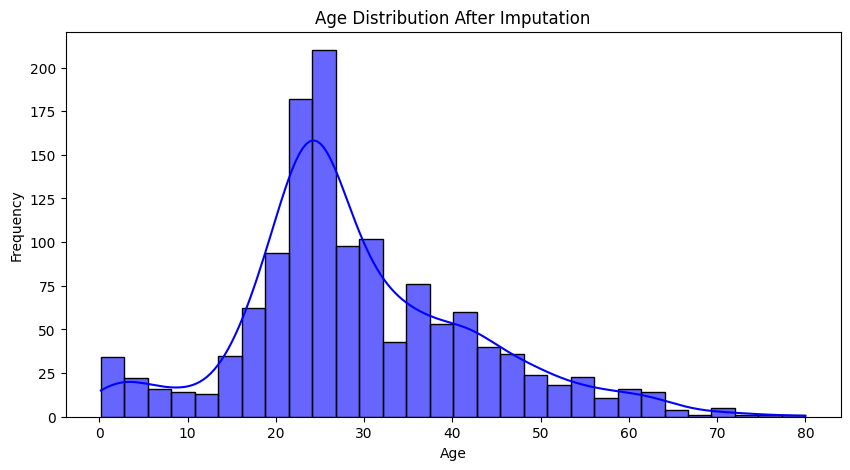

In [28]:
plt.figure(figsize=(10,5))
sns.histplot(df['age'], bins=30, kde=True, color='blue', alpha=0.6)
plt.title("Age Distribution After Imputation")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


From the distribution we see that it is smooth with a clear peak around 20-30 years old which alligns with our EDA. There are no large ariticial spikes at one specific age. The right skew of the data remains where we see more young passangers than old ones. Overall from this we can see that the impuation was successful we have no missing values and no extreme spikes or anomalies the KDE curve also suggests a smooth transisiton in values.

# Task 3: Encoding Categorical Variables

Below Im just reaffirming what categorical variables I have left. From the df below we see sex, pclass, and embarked are all categorical variables I need to encode. For the encoding method I chose here is my rationale:

Sex -> doensnt need OHE as its a binary categorical variable (at least in titanic days) I can simply map it to 0 and 1 using lable encoding. 
Pclass and embarked -> will have to be addressed using OHE becuase they have more than two categoreis 

In [29]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


In [30]:
# Encoding Sex:
df['sex'] = df['sex'].map({'female': 0, 'male': 1})
# Verifying the encoding was done correctly
print(df[['sex']].head())


   sex
0    0
1    1
2    0
3    1
4    0


In [31]:
# Encoding pclass and embarked 
# Pclass becomes pclass_2 and pclass_3 with 1st class as the reference
# Embarked becomes embarked_q and embarked_s with C as the reference 
df = pd.get_dummies(df, columns=['pclass', 'embarked'], drop_first=True)

#verifying
print(df.head())


   survived  sex      age  sibsp  parch      fare  pclass_2  pclass_3  \
0         1    0  29.0000      0      0  211.3375     False     False   
1         1    1   0.9167      1      2  151.5500     False     False   
2         0    0   2.0000      1      2  151.5500     False     False   
3         0    1  30.0000      1      2  151.5500     False     False   
4         0    0  25.0000      1      2  151.5500     False     False   

   embarked_Q  embarked_S  
0       False        True  
1       False        True  
2       False        True  
3       False        True  
4       False        True  


problem arrised here as the columsn i encoded should become numerical not boolean thefore we need to convert the boloean comlums to integers.

In [32]:
# Convert boolean columns to integers 
df[['pclass_2', 'pclass_3', 'embarked_Q', 'embarked_S']] = df[['pclass_2', 'pclass_3', 'embarked_Q', 'embarked_S']].astype(int)

# Verify the changes
print(df.head())
print(df.dtypes)  

   survived  sex      age  sibsp  parch      fare  pclass_2  pclass_3  \
0         1    0  29.0000      0      0  211.3375         0         0   
1         1    1   0.9167      1      2  151.5500         0         0   
2         0    0   2.0000      1      2  151.5500         0         0   
3         0    1  30.0000      1      2  151.5500         0         0   
4         0    0  25.0000      1      2  151.5500         0         0   

   embarked_Q  embarked_S  
0           0           1  
1           0           1  
2           0           1  
3           0           1  
4           0           1  
survived        int64
sex             int64
age           float64
sibsp           int64
parch           int64
fare          float64
pclass_2        int64
pclass_3        int64
embarked_Q      int64
embarked_S      int64
dtype: object


performing a final check before moving on to step 4....

In [33]:
# Check for any missing values in the dataset
print(df.isnull().sum())


survived      0
sex           0
age           0
sibsp         0
parch         0
fare          0
pclass_2      0
pclass_3      0
embarked_Q    0
embarked_S    0
dtype: int64


# Task 4: Feature Scaling

Before I moved on to feature scaling. I had the idea to combine fare into distinct buckets or quartiles as this could better address the skew in fare distribution as some paid extermely high amounts and most paid lower amounts. A by product of this is that higher fare likely corresponds with first-class passangers who likley had better chance of survival due to their position on the ship. Simmilalry sibsp and parch could be combined into family size -> instead of treating these features as seperate they could be summed inot a family simplifying the model. Furthermore from an intuitive standpoint passangers with family members could have had a higher survival rate due to assitance from eachother and group decision making. 

I already understand that pclass is a strong indicator of economic status, but I wanted to see if we could be more granular and analyze potential intra-class differences in survival. For example, within second class, did passengers who paid higher fares for better rooms have a higher survival rate than those who paid the minimum fare? This distinction might capture additional variation within pclass, which could be predictive of survival outcomes. Additionally, by binning fare instead of keeping it continuous, I aimed to reduce the influence of extreme outliers—since a few ultra-wealthy passengers paid disproportionately high amounts, keeping fare continuous might inflate their importance and cause the model to over-rely on them. Instead, fare_category allows us to maintain its predictive power while preventing it from skewing the model.


In [34]:
# creating a new feature summing sibsp and parch
df['family_size'] = df['sibsp'] + df['parch']

# Binning fare into quartiles 

df['fare_category'] = pd.qcut(df['fare'], q=4, labels=[1, 2, 3, 4])
# Convert to an integer 
df['fare_category'] = df['fare_category'].astype(int)


#verify the changes
print(df[['sibsp', 'parch', 'family_size', 'fare', 'fare_category']].head())
print(df['fare_category'].value_counts())


   sibsp  parch  family_size      fare  fare_category
0      0      0            0  211.3375              4
1      1      2            3  151.5500              4
2      1      2            3  151.5500              4
3      1      2            3  151.5500              4
4      1      2            3  151.5500              4
fare_category
1    337
3    328
4    323
2    321
Name: count, dtype: int64


with these changes lets move on to feature scalling the reason i did this before feature scaling is that I wanted the new features to be included in the scaling step. Lets evaluate what features need to be scaled to 0 and 1. The continous variables age, fare, the engineered features family_size. Categorically encoded variables are already in discrete ordinal values like fare_cateogry.

In [35]:
# Define numerical columns to scale
numericalFeatures = ['age', 'fare', 'family_size']
scalerStandard = StandardScaler()
scalerMinmax = MinMaxScaler()

# StandardScaler
dfStandardized = df.copy()
dfStandardized[numericalFeatures] = scalerStandard.fit_transform(dfStandardized[numericalFeatures])

# MinMaxScaler
dfNormalized = df.copy()
dfNormalized[numericalFeatures] = scalerMinmax.fit_transform(dfNormalized[numericalFeatures])

print("Standardized Data:")
print(dfStandardized.head())
print("\nNormalized Data:")
print(dfNormalized.head())


Standardized Data:
   survived  sex       age  sibsp  parch      fare  pclass_2  pclass_3  \
0         1    0 -0.019783      0      0  3.442584         0         0   
1         1    1 -2.145175      1      2  2.286639         0         0   
2         0    0 -2.063189      1      2  2.286639         0         0   
3         0    1  0.055899      1      2  2.286639         0         0   
4         0    0 -0.322510      1      2  2.286639         0         0   

   embarked_Q  embarked_S  family_size  fare_category  
0           0           1    -0.558346              4  
1           0           1     1.336749              4  
2           0           1     1.336749              4  
3           0           1     1.336749              4  
4           0           1     1.336749              4  

Normalized Data:
   survived  sex       age  sibsp  parch      fare  pclass_2  pclass_3  \
0         1    0  0.361169      0      0  0.412503         0         0   
1         1    1  0.009395      1 

In [36]:
# double check that fare_category is still intact after scaling

print(dfStandardized['fare_category'].value_counts())  
print(dfNormalized['fare_category'].value_counts())  


fare_category
1    337
3    328
4    323
2    321
Name: count, dtype: int64
fare_category
1    337
3    328
4    323
2    321
Name: count, dtype: int64


Now that we know fare_category is still intact lets compare standadization vs normalisation by plotting the dsitributions

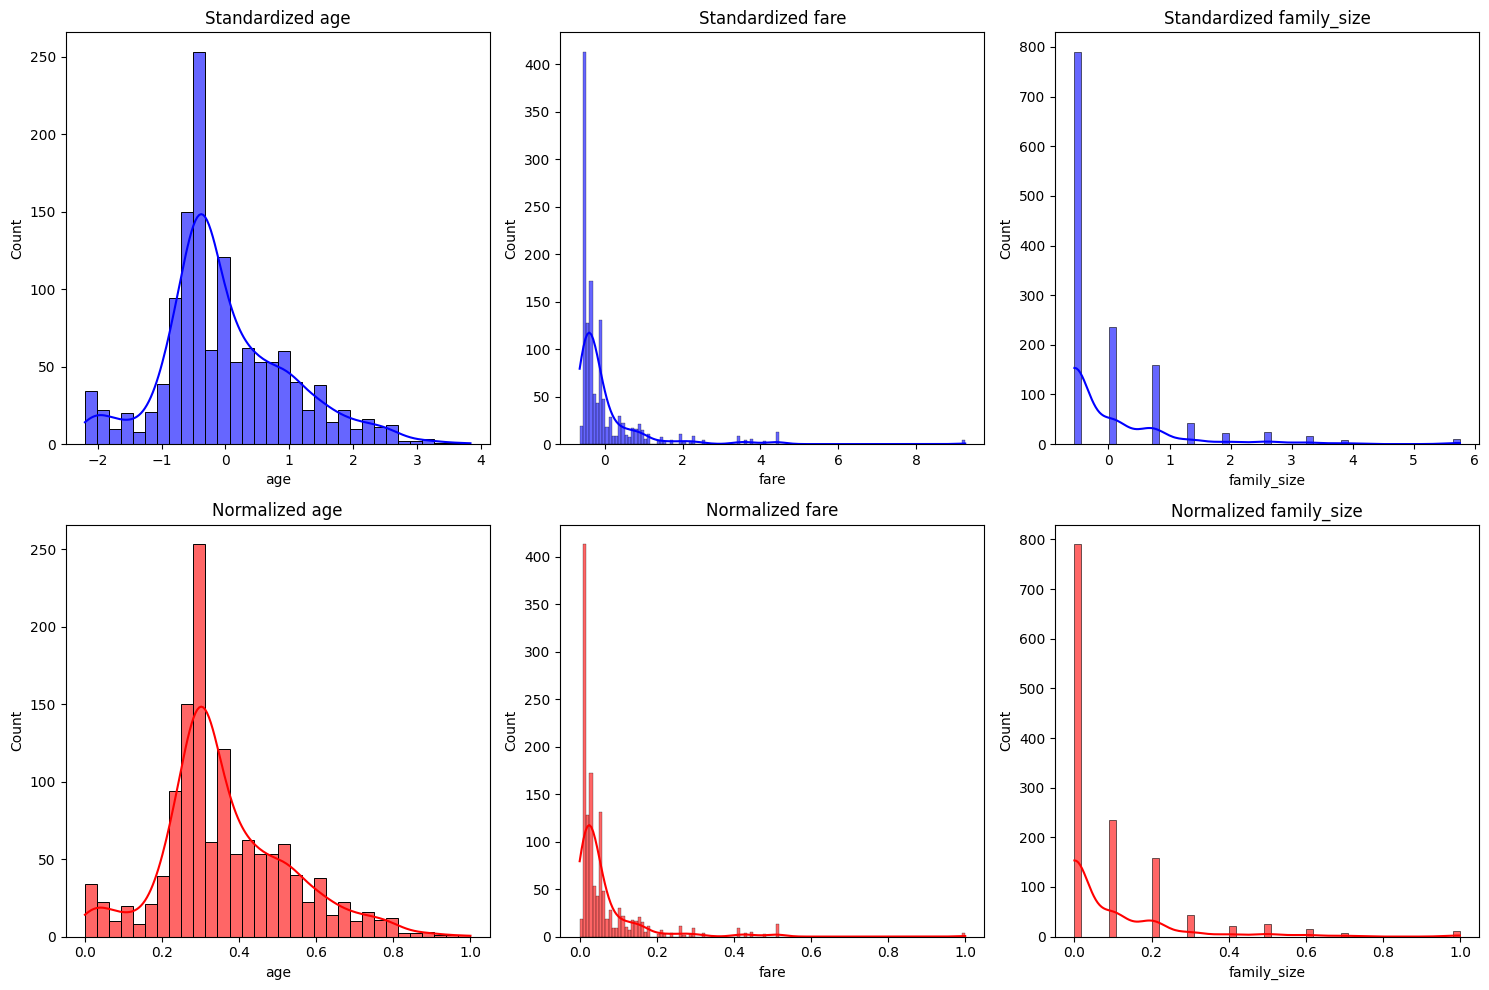

In [37]:
features_to_compare = ['age', 'fare', 'family_size']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Standardized distribution
for i, feature in enumerate(features_to_compare):
    sns.histplot(dfStandardized[feature], ax=axes[0, i], kde=True, color="blue", alpha=0.6)
    axes[0, i].set_title(f"Standardized {feature}")

# normalized distribution
for i, feature in enumerate(features_to_compare):
    sns.histplot(dfNormalized[feature], ax=axes[1, i], kde=True, color="red", alpha=0.6)
    axes[1, i].set_title(f"Normalized {feature}")

# layout adjustements
plt.tight_layout()
plt.show()


Standardization observations: 
- distributions are all centered around zero which is expceted
- Age maintains a right-skewed distribution 
- fare is highly right skewed with extreme outliers meaning standardisation did not fix this
- family_size is mostly 0, 1, 2, indicating many passengers traveled alone or in small groups.

Normalization observations:
- age, fare, and family_size now strictly fall within 0,1.
- age and family_size maintain their original distributions, just compressed into a smaller range.
- fare is still right-skewed, meaning MinMaxScaler does not adjust for outliers


reading from our slides: I will first puruse standardization as:
- The age feature follows a roughly normal distribution, making standardization a natural fit.
- and it is wiedely used in regression-based models which is what our goal is. 

# Task 5: Data Splitting 

Using the hint from the assignment I will attempt to use stratification for sampling. 

Since the titanic dataset has a class imbalance fewer survivors than non survivors. Stratified sampling will ensure the split of original survival rate is maintained. It will prevent bias towards majority calss predictions improving the performance of the model.


I will use the 80-10-10 split:

80 % -> Training data:
- Model will learn patternes from a large protion of the data.
- Will work towards preventing underfitting

10% -> Validation:
- Need to ensure the validation set is not too small becuase this could lead to poor generalisation 

10% -> Test:



In [38]:
# here I features (X) and target variable (y)
X = dfStandardized.drop(columns=['survived'])  # Features
y = dfStandardized['survived']  # Target variable

# Split 80-20 (20 corresponding to tempoary set)
xTrain, xTemp, yTrain, yTemp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# tempory set is split to 10-10
xVal, xTest, yVal, yTest = train_test_split(
    xTemp, yTemp, test_size=0.5, random_state=42, stratify=yTemp
)

# Double check everyhting is correct
print(f"Training Set: {xTrain.shape}, Validation Set: {xVal.shape}, Test Set: {xTest.shape}")


Training Set: (1047, 11), Validation Set: (131, 11), Test Set: (131, 11)


In [39]:
splitDistribution = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Total Samples": [len(yTrain), len(yVal), len(yTest)],
    "Survival Rate (%)": [yTrain.mean() * 100, yVal.mean() * 100, yTest.mean() * 100]
})

# here i display the stratification results
print(splitDistribution)


          Set  Total Samples  Survival Rate (%)
0       Train           1047          38.204394
1  Validation            131          38.167939
2        Test            131          38.167939


# Task 6: Addressing Class Imbalance

The titanic is an imbalanced dataset (38% survival rate) meaning the model might favour predicting non survivors,
I could randomly duplicate instances of the minority class but this could lead to overfiittng issues and also doesnt introduce variability in the model. Undersampling the majority class would lead to the loss of valuable information in the majority class. With less training data the model may fail to caputer patterns and variance of the smaller data set may make predictions worse. 

For these reasons I will be pursuing SMOTE:
- it will create new realisitc samples y interpolating exisiting minority class samples i.e survivors
- We wont loose valualbe information in the majority class 
- SMOTE will capture patterns in the minority class (since survival is a complex decsion based on many factors) and it wont treat them as noise
- In essence I want to use SMOTE becuase it will create diverse synthetic examples instead of simple duplicates


I didnt choose ADASYN it focuses on the harder to learn minority class examples and I wont run the risk of introducitng more variation creating noise in the dataset. 

In [40]:

smote = SMOTE(random_state=42)
xTrainBalanced, yTrainBalanced = smote.fit_resample(xTrain, yTrain)

# verifying the new class distribution after SMOTE
balancedClassDistribution = pd.DataFrame({
    "Set": ["Original Train", "Balanced Train"],
    "Total Samples": [len(yTrain), len(yTrainBalanced)],
    "Survival Rate (%)": [yTrain.mean() * 100, yTrainBalanced.mean() * 100]
})

# here I just display the results
print(balancedClassDistribution)


              Set  Total Samples  Survival Rate (%)
0  Original Train           1047          38.204394
1  Balanced Train           1294          50.000000


Before SMOTE we had 1047 training samples
After SMOTE we have 1294 training samles meaning we created 247 new synthetic samples

What is good about this approach:
- If the data set remained unbalanced the majority class "non survivors" would have been favoured
- The model will be "forced" to learn features that differentiate survivors from non-survivors instead of predicting based on class frequency
- The synthetic examples are realisitc and resemble real passangers improving the diversity of training data.

What could go wrong with this approach:
- In reality more people did not survive if this real-world data is not balanced than the artificially balanced data may not perform well on test data

# Task 7: Feature Selection

Know I will return to evaluating what features I am working with. Working through this process I can understand that it is easy to get way to caught up into completing one step of the pipeline without keeping track of the overall big picture/goal of what I am doing. And going forwards I would really like to note down on a paper or whiteboard my progress and thoughts as I proceed with a project like this. 

In this step I want to reduce overfitting by eliminating some uncessary complexity I might have added. Linked to this remove irrelevant or redunadnt features. 

Plan for doing this:
1. Eliminate low-variance features
2. Remove highly correlated features -> can lead to multicollinearity

In [41]:
print(xTrainBalanced.dtypes)


sex                int64
age              float64
sibsp              int64
parch              int64
fare             float64
pclass_2           int64
pclass_3           int64
embarked_Q         int64
embarked_S         int64
family_size      float64
fare_category      int64
dtype: object


/var/folders/yl/65z9g7mx6y1bg414kdj3sw0w0000gn/T/ipykernel_50553/250226669.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_variance.index, y=feature_variance.values, palette="viridis")


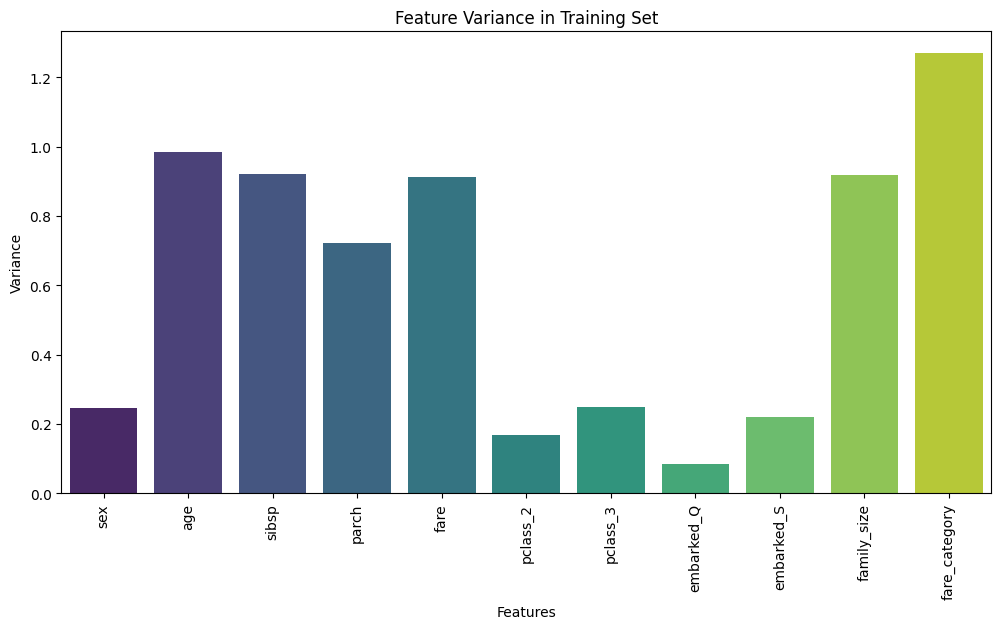

In [42]:
# Here I just want ot visualse varaince features: 

feature_variance = xTrainBalanced.var()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_variance.index, y=feature_variance.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Feature Variance in Training Set")
plt.xlabel("Features")
plt.ylabel("Variance")
plt.show()


Interpreting feature variance plot:
- High-variance features -> fare_category, family_size, age, fare 
- Moderate-variance features -> sibsp and parch have moderate variance could be redunandt with family_size
- Low-variance featrues -> sex, pclass_2, pclass_3, embarked_Q, and embarked_S have low variance 
Lets look at these low variance features in more depth with a correlation analysis. 

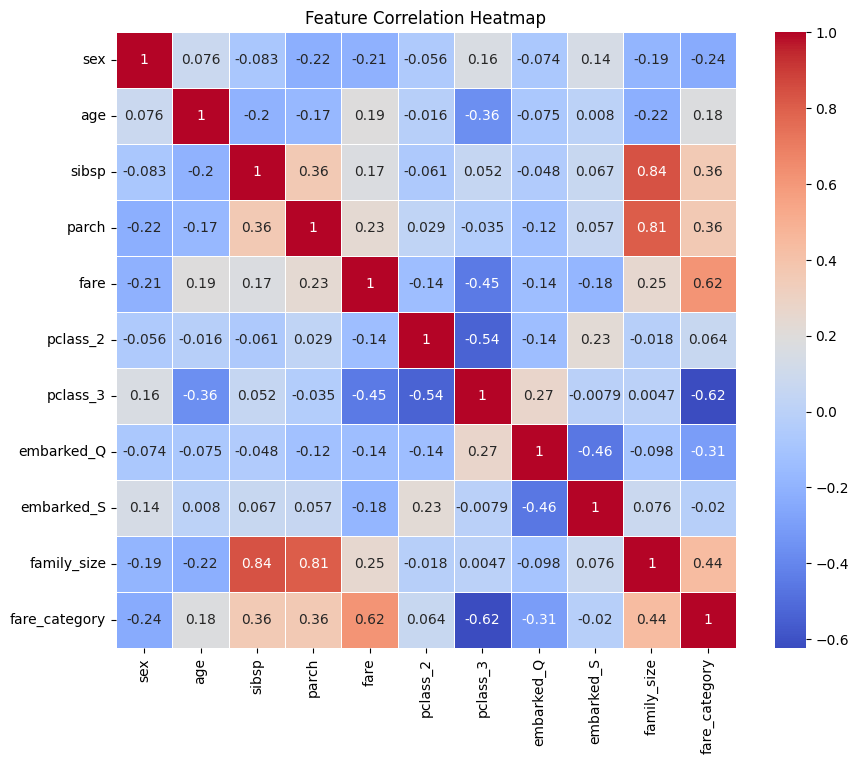

In [43]:
corr_matrix = xTrainBalanced.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


Candidates for removal: 
1. Highly correlated (expected) features:
    - sibsp and parch have a very strong correlation (0.84 and 0.81) with family_size meaning they mostly provide reduandant information
    - fare and fare_category have a correlation of 0.62 suggesting overlap which is expected as we binned them
    - Meaning since we already combined sibsp and parch into family_size we can remove them and fare is in fare_category so we can remove them
2. Moderatly correlated features:
    - fare_category and family_size have a moderate correlation of 0.44, meaning they may still provide unique info
3. Weakly Correlated Features:
    - sex, age, pclass, and embarked don’t have strong correlations, meaning they likely contribute unique information.


Takeaways:
Keep: sex, age, pclass_2, pclass_3, fare_category, family_size
Drop due to redundancy with family_size: sibsp, parch
Decision fare_category vs fare: We should only keep one -> fare_category is an interpretable group while precise pricing data we keep fare


In [44]:
# Drop redundant features
xTrainBalanced.drop(columns=['sibsp', 'parch', 'fare'], inplace=True)

# veryfing 
print("Remaining Features:", xTrainBalanced.columns)


Remaining Features: Index(['sex', 'age', 'pclass_2', 'pclass_3', 'embarked_Q', 'embarked_S',
       'family_size', 'fare_category'],
      dtype='object')


Why do we carry out tasks 6 and 7 after splitting the dataset into training, validation, and test sets? Could
we have conducted them on the entire dataset instead? Please elaborate on your answer. 

Answer: 

2 main things we address by doing this:

1. Prevent data leakage: 
    - applying SMOTE or features selection on the entire dataset before splitting, information from the validation and tests sets leak inot the training set.
    - We want an independent test set -> therfore we should evaluate our model on complelty unseen data.

2. Fair evaluation of model:
    - If we remove features based on the entire dataset we may accidnetly optimise our modle on information not pressent in its deployment. 
    - Oversampling technqiues like SMOTE create synthetic samples which can bias feature selection if applied before splitting
    - In essence feature selection and class balancing only on the training set ensure that the validation and test sets remain untouched for fair evaluation. 

Could we have done them before splitting?
    - Modifying the dataset before splitting incurs the following risks:
        1. Leakage between training and test sets
        2. Selecting features based on the entire dataset instead of what the model has access to during training
        3. Our model has an unfair advantage on the validation/test data

# Task 8: Training a Logistic Regression Model

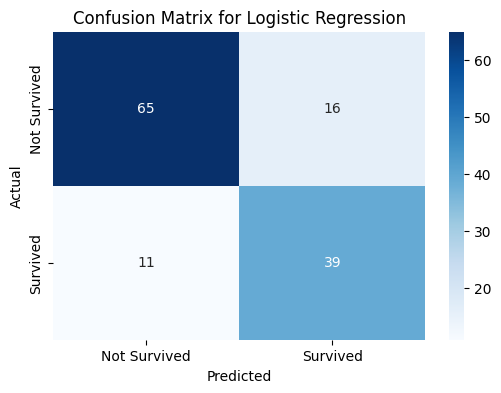

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83        81
           1       0.71      0.78      0.74        50

    accuracy                           0.79       131
   macro avg       0.78      0.79      0.79       131
weighted avg       0.80      0.79      0.80       131



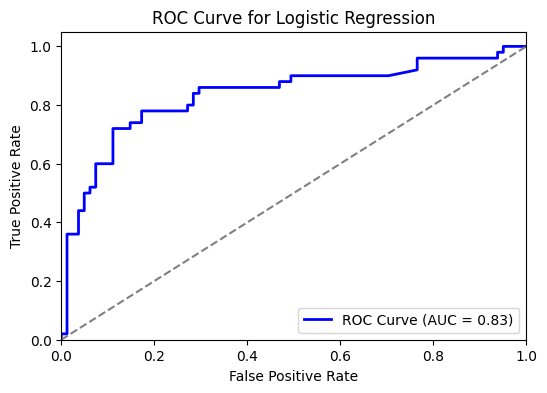

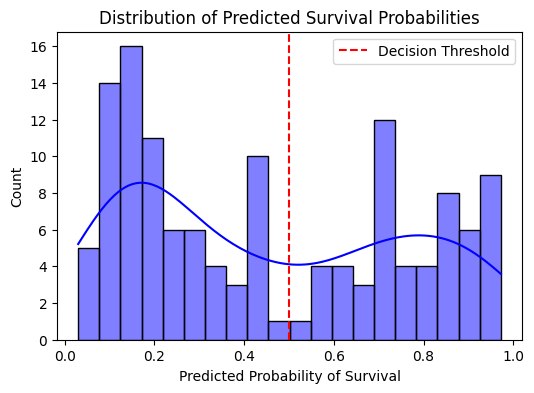

In [45]:
# had an issue before with a typo had to check all featues where balanced
xVal = xVal[xTrainBalanced.columns]

# initialising
logRegression = LogisticRegression(max_iter=1000, random_state=42)

# Training model on the balanced data set
logRegression.fit(xTrainBalanced, yTrainBalanced)

# predicting on the validation set
yValPredicted = logRegression.predict(xVal)
yValProb = logRegression.predict_proba(xVal)[:, 1]  

# confusion matrix plot
conf_matrix = confusion_matrix(yVal, yValPredicted)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100 

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# classification report
print("Classification Report:\n", classification_report(yVal, yValPredicted))

# Plotting the ROC Curve
fpr, tpr, _ = roc_curve(yVal, yValProb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.show()

# Lastly a histogram of predicted probabilities
plt.figure(figsize=(6, 4))
sns.histplot(yValProb, bins=20, kde=True, color='blue')
plt.axvline(0.5, color='red', linestyle='--', label="Decision Threshold")
plt.xlabel("Predicted Probability of Survival")
plt.ylabel("Count")
plt.title("Distribution of Predicted Survival Probabilities")
plt.legend()
plt.show()
